In [41]:
# Standard libraries
import os
import io
import pickle
import warnings
import zipfile

# Numerical and data manipulation libraries
import numpy as np
import pandas as pd
import itertools

# Statistical libraries
import scipy.stats as ss
from scipy import stats
from scipy.stats import f_oneway, randint
from scipy.sparse import csr_matrix

# Visualization libraries
import matplotlib.pyplot as plt
import seaborn as sns
import matplotlib.ticker as mtick

# Scikit-learn preprocessing and model selection
from sklearn.impute import KNNImputer
from sklearn.preprocessing import MinMaxScaler, OrdinalEncoder, LabelEncoder
from sklearn.model_selection import train_test_split, StratifiedKFold, cross_val_score, RandomizedSearchCV, PredefinedSplit

# Scikit-learn feature selection
from sklearn.feature_selection import f_classif, SelectKBest, mutual_info_classif, RFE, RFECV

# Scikit-learn models
from sklearn.linear_model import LogisticRegression, LassoCV
from sklearn.tree import DecisionTreeClassifier
from sklearn.ensemble import RandomForestClassifier, GradientBoostingClassifier, HistGradientBoostingClassifier, AdaBoostClassifier, VotingClassifier, BaggingClassifier, StackingClassifier
from sklearn.neighbors import KNeighborsClassifier
from sklearn.naive_bayes import GaussianNB
from sklearn.neural_network import MLPClassifier
from xgboost import XGBClassifier

# Scikit-learn metrics
from sklearn.metrics import make_scorer, precision_score, recall_score, f1_score, classification_report, confusion_matrix, accuracy_score

# Seaborn settings
sns.set()

# Ignore warnings
warnings.filterwarnings('ignore')

Import Datasets

In [42]:
X_train = pd.read_csv('datasets/final_data_train_delivery1.csv', index_col=0)
y_train = pd.read_csv('datasets/scaled_target_train_delivery1.csv', index_col=0)
X_val = pd.read_csv('datasets/final_data_val_delivery1.csv', index_col=0)
y_val = pd.read_csv('datasets/scaled_target_val_delivery1.csv', index_col=0)
X_test = pd.read_csv('datasets/final_data_test_delivery1.csv', index_col=0)

In [43]:
# get only 2% of the data
X_train = X_train.sample(frac=0.02, random_state=1)
y_train = y_train.loc[X_train.index]
X_val = X_val.sample(frac=0.02, random_state=1)
y_val = y_val.loc[X_val.index]
X_test = X_test.sample(frac=0.02, random_state=1)


# 4. Modelling

## Baseline Function

In [44]:
def evaluate_model(model, X_train, y_train, X_val, y_val):
    # Train the model
    model.fit(X_train, y_train)
    
    # Make predictions
    train_preds = model.predict(X_train)
    val_preds = model.predict(X_val)
    
    # Compute metrics
    metrics = {
        "Train Accuracy": accuracy_score(y_train, train_preds),
        "Validation Accuracy": accuracy_score(y_val, val_preds),
        "Train F1 Macro": f1_score(y_train, train_preds, average='macro'),
        "Validation F1 Macro": f1_score(y_val, val_preds, average='macro')
    }
    
    # Print metrics
    print("Training Data Evaluation:")
    print(f"Accuracy (Train): {metrics['Train Accuracy']:.4f}")
    print(f"F1 Macro (Train): {metrics['Train F1 Macro']:.4f}")
    
    print("\nValidation Data Evaluation:")
    print(f"Accuracy (Validation): {metrics['Validation Accuracy']:.4f}")
    print(f"F1 Macro (Validation): {metrics['Validation F1 Macro']:.4f}")
    
    print("\nClassification Report (Validation):")
    print(classification_report(y_val, val_preds))

    # Determine class labels from y_train for the confusion matrix
    labels = np.unique(y_train)  # Get unique labels directly from the training data
    
    # Generate confusion matrix
    conf_matrix = confusion_matrix(y_val, val_preds)
    plt.figure(figsize=(8, 6))
    sns.heatmap(conf_matrix, annot=True, fmt='d', cmap='Blues', 
                xticklabels=labels, yticklabels=labels)
    plt.title("Confusion Matrix (Validation)")
    plt.xlabel("Predicted")
    plt.ylabel("Actual")
    plt.show()
    
    return metrics


### **Logistic Regression (Baseline)**

Training Data Evaluation:
Accuracy (Train): 0.6514
F1 Macro (Train): 0.2231

Validation Data Evaluation:
Accuracy (Validation): 0.6514
F1 Macro (Validation): 0.2453

Classification Report (Validation):
              precision    recall  f1-score   support

           0       0.00      0.00      0.00        52
           1       0.69      0.94      0.79      1136
           2       0.00      0.00      0.00       250
           3       0.59      0.55      0.57       601
           4       0.43      0.30      0.35       150
           5       0.00      0.00      0.00        21
           7       0.00      0.00      0.00         2

    accuracy                           0.65      2212
   macro avg       0.24      0.26      0.25      2212
weighted avg       0.54      0.65      0.59      2212



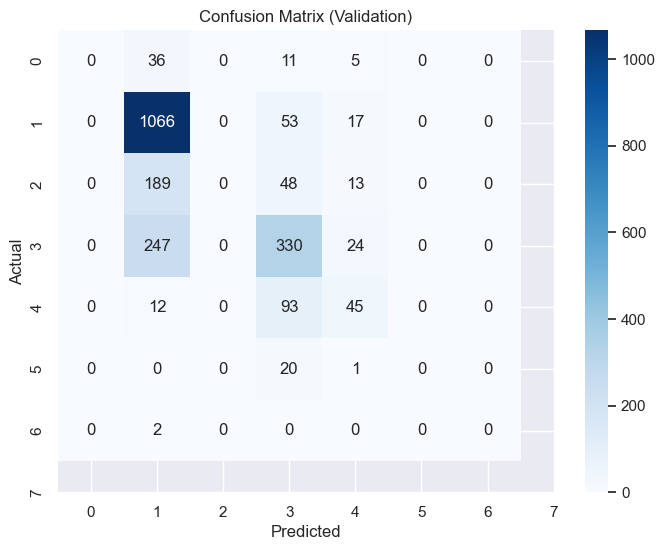

In [45]:
lr = LogisticRegression()
lr_metrics = evaluate_model(lr, X_train, y_train, X_val, y_val)

### **Random Forest (Baseline)**

Training Data Evaluation:
Accuracy (Train): 1.0000
F1 Macro (Train): 1.0000

Validation Data Evaluation:
Accuracy (Validation): 0.6854
F1 Macro (Validation): 0.3007

Classification Report (Validation):
              precision    recall  f1-score   support

           0       0.33      0.10      0.15        52
           1       0.73      0.94      0.82      1136
           2       0.25      0.02      0.04       250
           3       0.63      0.62      0.63       601
           4       0.55      0.40      0.46       150
           5       0.00      0.00      0.00        21
           7       0.00      0.00      0.00         2

    accuracy                           0.69      2212
   macro avg       0.36      0.30      0.30      2212
weighted avg       0.62      0.69      0.63      2212



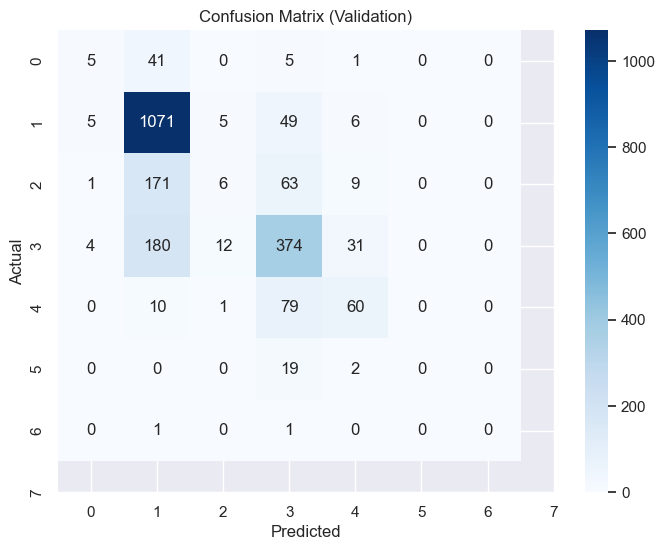

In [46]:
rf = RandomForestClassifier(random_state=42, class_weight='balanced')
rf_metrics = evaluate_model(rf, X_train, y_train, X_val, y_val)

### **AdaBoost**

Training Data Evaluation:
Accuracy (Train): 0.6071
F1 Macro (Train): 0.1655

Validation Data Evaluation:
Accuracy (Validation): 0.6207
F1 Macro (Validation): 0.1883

Classification Report (Validation):
              precision    recall  f1-score   support

           0       0.00      0.00      0.00        52
           1       0.69      0.92      0.79      1136
           2       0.00      0.00      0.00       250
           3       0.51      0.54      0.53       601
           4       0.00      0.00      0.00       150
           5       0.00      0.00      0.00        21
           7       0.00      0.00      0.00         2

    accuracy                           0.62      2212
   macro avg       0.17      0.21      0.19      2212
weighted avg       0.49      0.62      0.55      2212



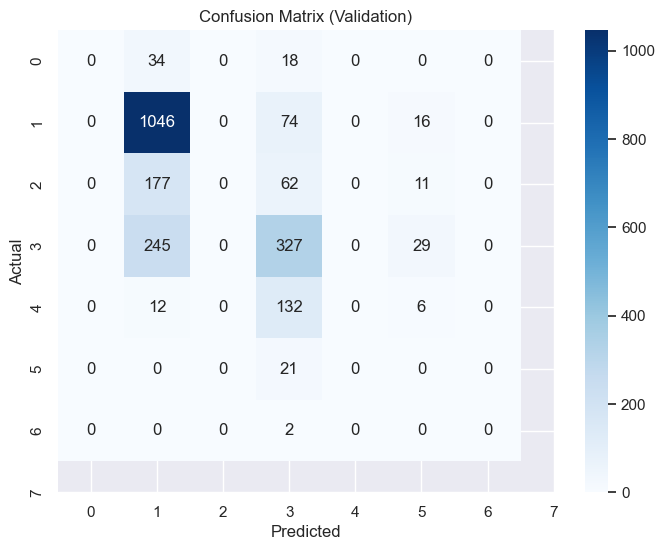

In [47]:
adaboost = AdaBoostClassifier(random_state=42)
adaboost_metrics = evaluate_model(adaboost, X_train, y_train, X_val, y_val)

### **Gradient Boosting**

Training Data Evaluation:
Accuracy (Train): 0.7503
F1 Macro (Train): 0.6682

Validation Data Evaluation:
Accuracy (Validation): 0.7134
F1 Macro (Validation): 0.3214

Classification Report (Validation):
              precision    recall  f1-score   support

           0       0.30      0.13      0.19        52
           1       0.75      0.97      0.85      1136
           2       0.30      0.03      0.05       250
           3       0.70      0.66      0.68       601
           4       0.53      0.46      0.49       150
           5       0.00      0.00      0.00        21
           7       0.00      0.00      0.00         2

    accuracy                           0.71      2212
   macro avg       0.37      0.32      0.32      2212
weighted avg       0.65      0.71      0.66      2212



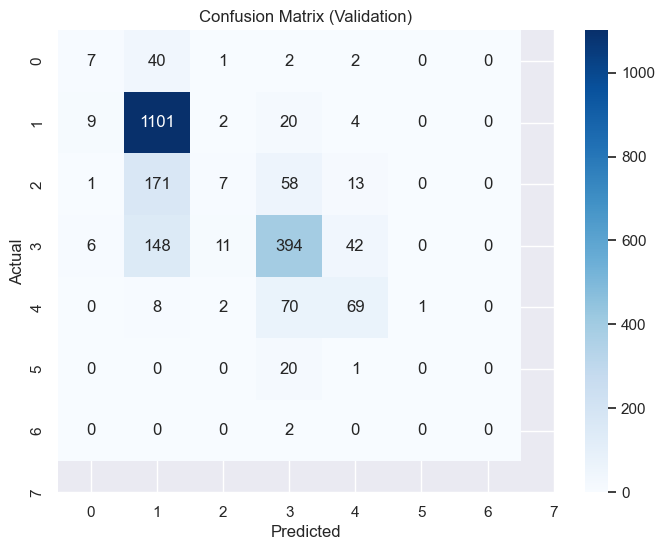

In [48]:
gb = GradientBoostingClassifier(random_state=42)
gb_metrics = evaluate_model(gb, X_train, y_train, X_val, y_val)

### **HistGradientBoosting**

Training Data Evaluation:
Accuracy (Train): 0.7122
F1 Macro (Train): 0.4437

Validation Data Evaluation:
Accuracy (Validation): 0.5665
F1 Macro (Validation): 0.2807

Classification Report (Validation):
              precision    recall  f1-score   support

           0       0.07      0.15      0.10        52
           1       0.73      0.75      0.74      1136
           2       0.14      0.08      0.10       250
           3       0.55      0.53      0.54       601
           4       0.31      0.37      0.34       150
           5       0.10      0.29      0.15        21
           7       0.00      0.00      0.00         2

    accuracy                           0.57      2212
   macro avg       0.27      0.31      0.28      2212
weighted avg       0.57      0.57      0.56      2212



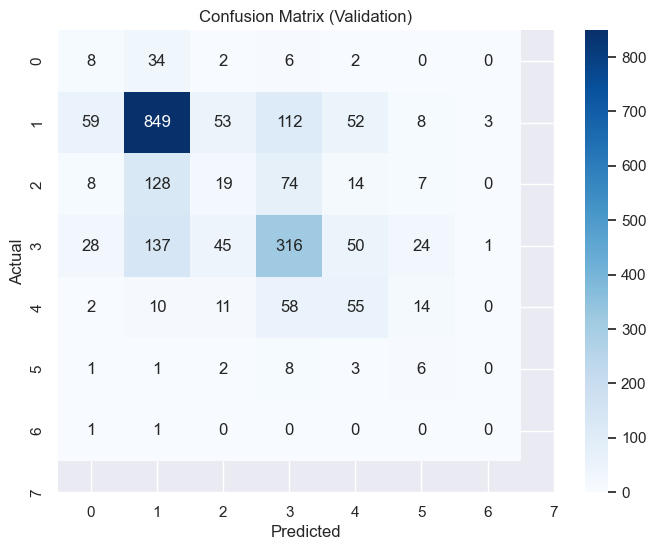

In [49]:
hist_gb = HistGradientBoostingClassifier(random_state=42)
hist_gb_metrics = evaluate_model(hist_gb, X_train, y_train, X_val, y_val)

### **NaiveBayes**

Training Data Evaluation:
Accuracy (Train): 0.5648
F1 Macro (Train): 0.3888

Validation Data Evaluation:
Accuracy (Validation): 0.5669
F1 Macro (Validation): 0.3102

Classification Report (Validation):
              precision    recall  f1-score   support

           0       0.15      0.40      0.22        52
           1       0.74      0.86      0.79      1136
           2       0.19      0.09      0.12       250
           3       0.71      0.20      0.31       601
           4       0.35      0.63      0.45       150
           5       0.10      0.71      0.18        21
           7       0.05      1.00      0.10         2

    accuracy                           0.57      2212
   macro avg       0.33      0.56      0.31      2212
weighted avg       0.62      0.57      0.54      2212



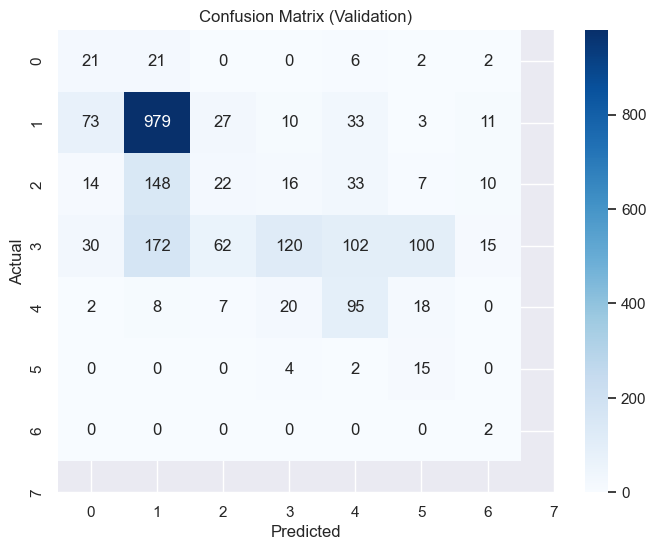

In [50]:
gnb_model = GaussianNB()
gnb_metrics = evaluate_model(gnb_model, X_train, y_train, X_val, y_val)

### **MultiLayerPerceptron**

Training Data Evaluation:
Accuracy (Train): 0.6914
F1 Macro (Train): 0.3297

Validation Data Evaluation:
Accuracy (Validation): 0.6854
F1 Macro (Validation): 0.2940

Classification Report (Validation):
              precision    recall  f1-score   support

           0       0.25      0.08      0.12        52
           1       0.74      0.94      0.82      1136
           2       0.13      0.01      0.02       250
           3       0.63      0.63      0.63       601
           4       0.50      0.45      0.47       150
           5       0.00      0.00      0.00        21
           7       0.00      0.00      0.00         2

    accuracy                           0.69      2212
   macro avg       0.32      0.30      0.29      2212
weighted avg       0.60      0.69      0.63      2212



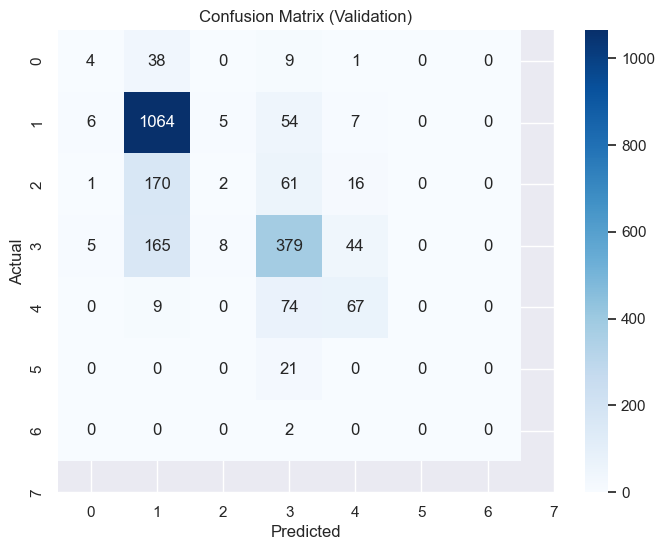

In [51]:
mlp = MLPClassifier(random_state=42)
mlp_metrics = evaluate_model(mlp, X_train, y_train, X_val, y_val)

### **KNN**

Training Data Evaluation:
Accuracy (Train): 0.7274
F1 Macro (Train): 0.3817

Validation Data Evaluation:
Accuracy (Validation): 0.6392
F1 Macro (Validation): 0.3869

Classification Report (Validation):
              precision    recall  f1-score   support

           0       0.23      0.10      0.14        52
           1       0.71      0.91      0.80      1136
           2       0.13      0.06      0.09       250
           3       0.61      0.50      0.55       601
           4       0.42      0.35      0.38       150
           5       0.50      0.05      0.09        21
           7       1.00      0.50      0.67         2

    accuracy                           0.64      2212
   macro avg       0.52      0.35      0.39      2212
weighted avg       0.59      0.64      0.60      2212



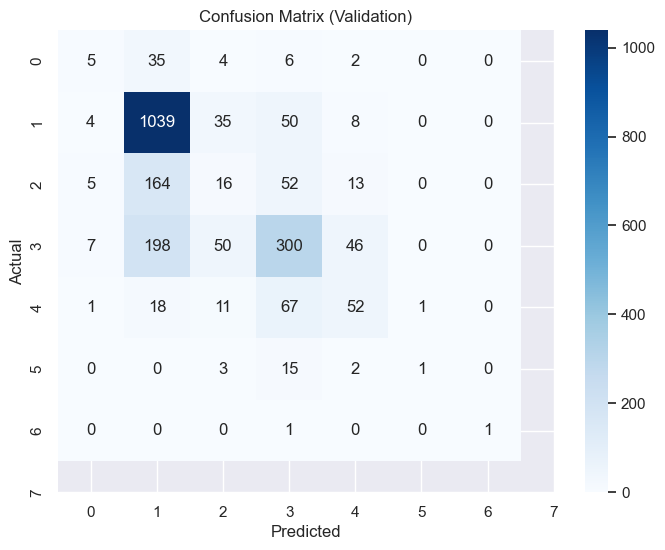

In [52]:
knn = KNeighborsClassifier()
knn_metrics = evaluate_model(knn, X_train, y_train, X_val, y_val)

### **XG Boost**

Training Data Evaluation:
Accuracy (Train): 0.9507
F1 Macro (Train): 0.9588

Validation Data Evaluation:
Accuracy (Validation): 0.7297
F1 Macro (Validation): 0.3376

Classification Report (Validation):
              precision    recall  f1-score   support

           0       0.57      0.15      0.24        52
           1       0.80      0.96      0.87      1136
           2       0.18      0.06      0.09       250
           3       0.70      0.73      0.71       601
           4       0.48      0.42      0.45       150
           5       0.00      0.00      0.00        21
           7       0.00      0.00      0.00         2

    accuracy                           0.73      2212
   macro avg       0.39      0.33      0.34      2212
weighted avg       0.67      0.73      0.69      2212



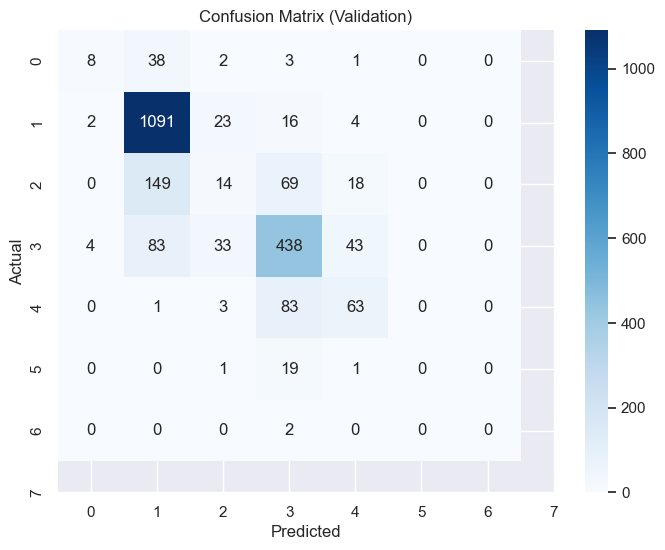

In [53]:
xgb = XGBClassifier(random_state=42)
xgb_metrics = evaluate_model(xgb, X_train, y_train, X_val, y_val)

### **Bagging Classifier**

Training Data Evaluation:
Accuracy (Train): 0.9808
F1 Macro (Train): 0.9770

Validation Data Evaluation:
Accuracy (Validation): 0.6686
F1 Macro (Validation): 0.3035

Classification Report (Validation):
              precision    recall  f1-score   support

           0       0.22      0.12      0.15        52
           1       0.75      0.92      0.83      1136
           2       0.18      0.07      0.10       250
           3       0.62      0.58      0.60       601
           4       0.47      0.42      0.44       150
           5       0.00      0.00      0.00        21
           7       0.00      0.00      0.00         2

    accuracy                           0.67      2212
   macro avg       0.32      0.30      0.30      2212
weighted avg       0.61      0.67      0.63      2212



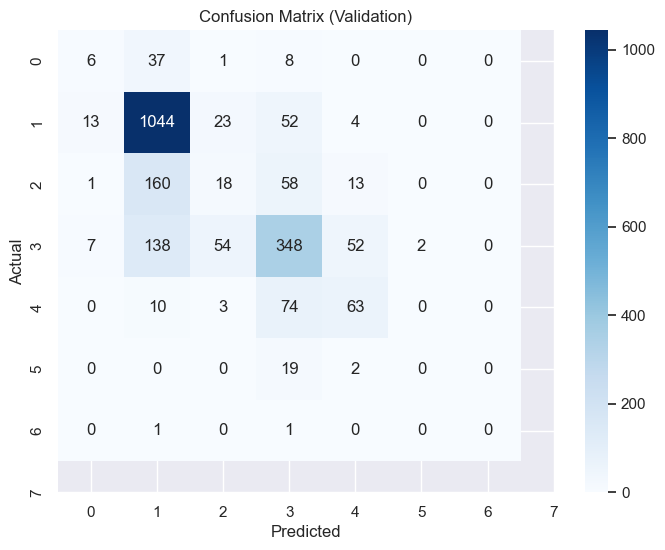

In [54]:
bagging = BaggingClassifier(random_state=42)
bagging_metrics = evaluate_model(bagging, X_train, y_train, X_val, y_val)

### **Comparisons**

In [55]:
# create a dataframe to store the metrics
metrics_df = pd.DataFrame([lr_metrics, rf_metrics, adaboost_metrics, gb_metrics, hist_gb_metrics, gnb_metrics, mlp_metrics, knn_metrics, xgb_metrics, bagging_metrics],
                          index=['Logistic Regression', 'Random Forest', 'AdaBoost', 'Gradient Boosting', 'HistGradientBoosting', 'Naive Bayes', 'MLP', 'KNN', 'XGBoost', 'Bagging'])

metrics_df

,Train Accuracy,Validation Accuracy,Train F1 Macro,Validation F1 Macro
Logistic Regression,0.651426,0.651447,0.223107,0.245290
Random Forest,1.000000,0.685353,1.000000,0.300729
AdaBoost,0.607062,0.620705,0.165516,0.188305
Gradient Boosting,0.750340,0.713382,0.668248,0.321416
HistGradientBoosting,0.712200,0.566456,0.443745,0.280707
Naive Bayes,0.564848,0.566908,0.388804,0.310216
MLP,0.691376,0.685353,0.329727,0.294032
KNN,0.727365,0.639241,0.381747,0.386886
XGBoost,0.950656,0.729656,0.958790,0.337633
Bagging,0.980761,0.668626,0.977008,0.303543


<Figure size 1200x600 with 0 Axes>

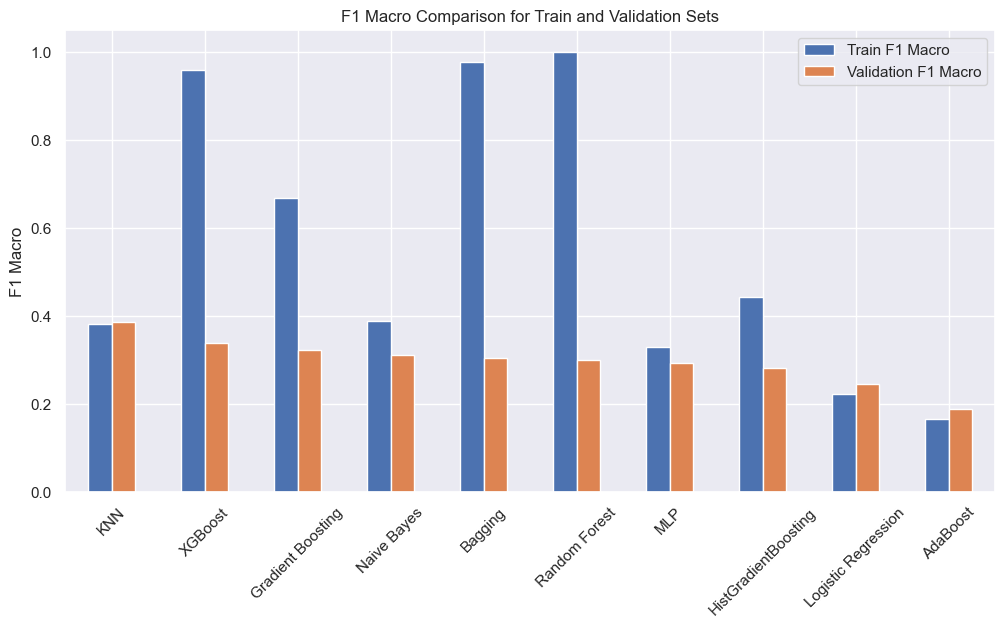

In [56]:
# create a plot comparing f1 scores for train and validation sets

def plot_metrics_df(metrics_df):
    plt.figure(figsize=(12, 6))
    metrics_df.sort_values('Validation F1 Macro', ascending=False, inplace=True)
    metrics_df[['Train F1 Macro', 'Validation F1 Macro']].plot(kind='bar', figsize=(12, 6), rot=45)
    plt.ylabel('F1 Macro')
    plt.title('F1 Macro Comparison for Train and Validation Sets')
    plt.show()

plot_metrics_df(metrics_df)


## Model Optimization

After evaluating baseline models, the goal now is to improve the performance of the best ones through hyperparameter tuning.

- Random Forest
- MLP
- XGBoost
- Bagging

### **Setting up Predefined Split** (Using the same we used for RFE)

In [57]:
X_combined = pd.concat([X_train, X_val])
y_combined = pd.concat([y_train, y_val])

# Create the test_fold array
test_fold = np.concatenate([
    np.full(len(X_train), -1),  # Assign -1 for training samples
    np.full(len(X_val), 0)     # Assign 0 for validation samples
])

# Define PredefinedSplit object
cv_strategy = PredefinedSplit(test_fold)

In [58]:
# Calculation of class weights
from sklearn.utils.class_weight import compute_class_weight

# Compute class weights
class_weights = compute_class_weight('balanced', classes=np.unique(y_combined), y=y_combined.values.ravel())
class_weight_dict = dict(zip(np.unique(y_combined), class_weights))

### **Random Forest (Optimized)**

In [59]:
# Define the parameter distribution
param_dist = {
    'n_estimators': randint(100, 500),      
    'max_depth': [5, 8, 10, 20],           
    'min_samples_split': [100, 500, 1000, 5000],  
    'min_samples_leaf': [100, 500, 1000, 5000] 
}

# Initialize the RandomForestClassifier
rf = RandomForestClassifier(random_state=42, class_weight=class_weight_dict)

# Set up RandomizedSearchCV
random_search = RandomizedSearchCV(
    estimator=rf,
    param_distributions=param_dist,
    n_iter=50,                
    cv=cv_strategy,      
    scoring='f1_macro',     
    verbose=2,
    n_jobs=-1,            
    random_state=42        
)

# Fit RandomizedSearchCV
random_search.fit(X_combined, y_combined)

# Get the best parameters 
best_params_rf = random_search.best_params_

# Model with best parameters
best_rf = RandomForestClassifier(
    n_estimators=best_params_rf['n_estimators'],
    max_depth=best_params_rf['max_depth'],
    min_samples_split=best_params_rf['min_samples_split'],
    min_samples_leaf=best_params_rf['min_samples_leaf'],
    random_state=42,
    class_weight=class_weight_dict
)
best_rf.fit(X_combined, y_combined)

print(f"Best parameters: {best_params_rf}")

Fitting 1 folds for each of 50 candidates, totalling 50 fits


/opt/anaconda3/lib/python3.12/site-packages/sklearn/base.py:1474: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  return fit_method(estimator, *args, **kwargs)
/opt/anaconda3/lib/python3.12/site-packages/sklearn/base.py:1474: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  return fit_method(estimator, *args, **kwargs)
/opt/anaconda3/lib/python3.12/site-packages/sklearn/base.py:1474: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  return fit_method(estimator, *args, **kwargs)
/opt/anaconda3/lib/python3.12/site-packages/sklearn/base.py:1474: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,),

[CV] END max_depth=10, min_samples_leaf=5000, min_samples_split=100, n_estimators=120; total time=   0.5s
[CV] END max_depth=20, min_samples_leaf=5000, min_samples_split=5000, n_estimators=230; total time=   0.6s


/opt/anaconda3/lib/python3.12/site-packages/sklearn/base.py:1474: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  return fit_method(estimator, *args, **kwargs)
/opt/anaconda3/lib/python3.12/site-packages/sklearn/base.py:1474: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  return fit_method(estimator, *args, **kwargs)


[CV] END max_depth=20, min_samples_leaf=5000, min_samples_split=100, n_estimators=260; total time=   0.7s
[CV] END max_depth=10, min_samples_leaf=5000, min_samples_split=100, n_estimators=370; total time=   0.9s


/opt/anaconda3/lib/python3.12/site-packages/sklearn/base.py:1474: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  return fit_method(estimator, *args, **kwargs)
/opt/anaconda3/lib/python3.12/site-packages/sklearn/base.py:1474: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  return fit_method(estimator, *args, **kwargs)


[CV] END max_depth=10, min_samples_leaf=1000, min_samples_split=5000, n_estimators=472; total time=   1.6s


/opt/anaconda3/lib/python3.12/site-packages/sklearn/base.py:1474: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  return fit_method(estimator, *args, **kwargs)


[CV] END max_depth=10, min_samples_leaf=500, min_samples_split=5000, n_estimators=287; total time=   1.1s
[CV] END max_depth=10, min_samples_leaf=500, min_samples_split=1000, n_estimators=314; total time=   2.2s
[CV] END max_depth=20, min_samples_leaf=1000, min_samples_split=500, n_estimators=274; total time=   1.2s


/opt/anaconda3/lib/python3.12/site-packages/sklearn/base.py:1474: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  return fit_method(estimator, *args, **kwargs)
/opt/anaconda3/lib/python3.12/site-packages/sklearn/base.py:1474: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  return fit_method(estimator, *args, **kwargs)
/opt/anaconda3/lib/python3.12/site-packages/sklearn/base.py:1474: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  return fit_method(estimator, *args, **kwargs)
/opt/anaconda3/lib/python3.12/site-packages/sklearn/base.py:1474: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,),

[CV] END max_depth=20, min_samples_leaf=100, min_samples_split=100, n_estimators=158; total time=   1.7s
[CV] END max_depth=8, min_samples_leaf=1000, min_samples_split=5000, n_estimators=154; total time=   0.6s
[CV] END max_depth=20, min_samples_leaf=5000, min_samples_split=100, n_estimators=230; total time=   0.6s


/opt/anaconda3/lib/python3.12/site-packages/sklearn/base.py:1474: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  return fit_method(estimator, *args, **kwargs)


[CV] END max_depth=5, min_samples_leaf=1000, min_samples_split=1000, n_estimators=120; total time=   0.7s
[CV] END max_depth=20, min_samples_leaf=500, min_samples_split=500, n_estimators=352; total time=   2.4s


/opt/anaconda3/lib/python3.12/site-packages/sklearn/base.py:1474: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  return fit_method(estimator, *args, **kwargs)
/opt/anaconda3/lib/python3.12/site-packages/sklearn/base.py:1474: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  return fit_method(estimator, *args, **kwargs)


[CV] END max_depth=5, min_samples_leaf=5000, min_samples_split=500, n_estimators=341; total time=   0.8s


/opt/anaconda3/lib/python3.12/site-packages/sklearn/base.py:1474: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  return fit_method(estimator, *args, **kwargs)


[CV] END max_depth=20, min_samples_leaf=500, min_samples_split=500, n_estimators=485; total time=   3.5s


/opt/anaconda3/lib/python3.12/site-packages/sklearn/base.py:1474: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  return fit_method(estimator, *args, **kwargs)
/opt/anaconda3/lib/python3.12/site-packages/sklearn/base.py:1474: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  return fit_method(estimator, *args, **kwargs)


[CV] END max_depth=8, min_samples_leaf=100, min_samples_split=500, n_estimators=152; total time=   1.3s
[CV] END max_depth=8, min_samples_leaf=5000, min_samples_split=5000, n_estimators=466; total time=   1.1s
[CV] END max_depth=10, min_samples_leaf=1000, min_samples_split=500, n_estimators=180; total time=   0.9s


/opt/anaconda3/lib/python3.12/site-packages/sklearn/base.py:1474: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  return fit_method(estimator, *args, **kwargs)
/opt/anaconda3/lib/python3.12/site-packages/sklearn/base.py:1474: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  return fit_method(estimator, *args, **kwargs)


[CV] END max_depth=8, min_samples_leaf=100, min_samples_split=500, n_estimators=443; total time=   4.2s
[CV] END max_depth=20, min_samples_leaf=1000, min_samples_split=5000, n_estimators=363; total time=   1.5s


/opt/anaconda3/lib/python3.12/site-packages/sklearn/base.py:1474: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  return fit_method(estimator, *args, **kwargs)
/opt/anaconda3/lib/python3.12/site-packages/sklearn/base.py:1474: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  return fit_method(estimator, *args, **kwargs)


[CV] END max_depth=8, min_samples_leaf=5000, min_samples_split=500, n_estimators=290; total time=   0.8s
[CV] END max_depth=8, min_samples_leaf=500, min_samples_split=500, n_estimators=153; total time=   1.1s


/opt/anaconda3/lib/python3.12/site-packages/sklearn/base.py:1474: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  return fit_method(estimator, *args, **kwargs)
/opt/anaconda3/lib/python3.12/site-packages/sklearn/base.py:1474: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  return fit_method(estimator, *args, **kwargs)


[CV] END max_depth=5, min_samples_leaf=1000, min_samples_split=500, n_estimators=487; total time=   2.7s
[CV] END max_depth=8, min_samples_leaf=500, min_samples_split=5000, n_estimators=261; total time=   1.2s
[CV] END max_depth=10, min_samples_leaf=5000, min_samples_split=1000, n_estimators=314; total time=   0.8s


/opt/anaconda3/lib/python3.12/site-packages/sklearn/base.py:1474: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  return fit_method(estimator, *args, **kwargs)
/opt/anaconda3/lib/python3.12/site-packages/sklearn/base.py:1474: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  return fit_method(estimator, *args, **kwargs)
/opt/anaconda3/lib/python3.12/site-packages/sklearn/base.py:1474: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  return fit_method(estimator, *args, **kwargs)


[CV] END max_depth=20, min_samples_leaf=5000, min_samples_split=5000, n_estimators=140; total time=   0.3s
[CV] END max_depth=20, min_samples_leaf=500, min_samples_split=5000, n_estimators=487; total time=   2.2s
[CV] END max_depth=8, min_samples_leaf=500, min_samples_split=5000, n_estimators=369; total time=   1.5s


/opt/anaconda3/lib/python3.12/site-packages/sklearn/base.py:1474: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  return fit_method(estimator, *args, **kwargs)
/opt/anaconda3/lib/python3.12/site-packages/sklearn/base.py:1474: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  return fit_method(estimator, *args, **kwargs)
/opt/anaconda3/lib/python3.12/site-packages/sklearn/base.py:1474: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  return fit_method(estimator, *args, **kwargs)


[CV] END max_depth=5, min_samples_leaf=5000, min_samples_split=100, n_estimators=437; total time=   1.0s
[CV] END max_depth=5, min_samples_leaf=5000, min_samples_split=5000, n_estimators=162; total time=   0.3s


/opt/anaconda3/lib/python3.12/site-packages/sklearn/base.py:1474: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  return fit_method(estimator, *args, **kwargs)
/opt/anaconda3/lib/python3.12/site-packages/sklearn/base.py:1474: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  return fit_method(estimator, *args, **kwargs)


[CV] END max_depth=5, min_samples_leaf=1000, min_samples_split=100, n_estimators=164; total time=   0.8s
[CV] END max_depth=10, min_samples_leaf=100, min_samples_split=5000, n_estimators=316; total time=   1.3s


/opt/anaconda3/lib/python3.12/site-packages/sklearn/base.py:1474: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  return fit_method(estimator, *args, **kwargs)
/opt/anaconda3/lib/python3.12/site-packages/sklearn/base.py:1474: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  return fit_method(estimator, *args, **kwargs)


[CV] END max_depth=5, min_samples_leaf=500, min_samples_split=1000, n_estimators=140; total time=   0.8s


/opt/anaconda3/lib/python3.12/site-packages/sklearn/base.py:1474: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  return fit_method(estimator, *args, **kwargs)


[CV] END max_depth=20, min_samples_leaf=500, min_samples_split=100, n_estimators=147; total time=   0.8s


/opt/anaconda3/lib/python3.12/site-packages/sklearn/base.py:1474: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  return fit_method(estimator, *args, **kwargs)


[CV] END max_depth=5, min_samples_leaf=1000, min_samples_split=100, n_estimators=443; total time=   2.1s


/opt/anaconda3/lib/python3.12/site-packages/sklearn/base.py:1474: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  return fit_method(estimator, *args, **kwargs)


[CV] END max_depth=20, min_samples_leaf=1000, min_samples_split=100, n_estimators=427; total time=   1.9s
[CV] END max_depth=10, min_samples_leaf=1000, min_samples_split=500, n_estimators=315; total time=   1.5s
[CV] END max_depth=10, min_samples_leaf=1000, min_samples_split=100, n_estimators=491; total time=   2.2s


/opt/anaconda3/lib/python3.12/site-packages/sklearn/base.py:1474: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  return fit_method(estimator, *args, **kwargs)
/opt/anaconda3/lib/python3.12/site-packages/sklearn/base.py:1474: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  return fit_method(estimator, *args, **kwargs)
/opt/anaconda3/lib/python3.12/site-packages/sklearn/base.py:1474: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  return fit_method(estimator, *args, **kwargs)


[CV] END max_depth=10, min_samples_leaf=1000, min_samples_split=100, n_estimators=478; total time=   2.3s
[CV] END max_depth=5, min_samples_leaf=1000, min_samples_split=5000, n_estimators=459; total time=   1.4s
[CV] END max_depth=20, min_samples_leaf=100, min_samples_split=500, n_estimators=395; total time=   3.4s


/opt/anaconda3/lib/python3.12/site-packages/sklearn/base.py:1474: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  return fit_method(estimator, *args, **kwargs)
/opt/anaconda3/lib/python3.12/site-packages/sklearn/base.py:1474: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  return fit_method(estimator, *args, **kwargs)
/opt/anaconda3/lib/python3.12/site-packages/sklearn/base.py:1474: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  return fit_method(estimator, *args, **kwargs)


[CV] END max_depth=10, min_samples_leaf=1000, min_samples_split=500, n_estimators=141; total time=   0.7s
[CV] END max_depth=8, min_samples_leaf=1000, min_samples_split=1000, n_estimators=326; total time=   1.6s
[CV] END max_depth=5, min_samples_leaf=1000, min_samples_split=500, n_estimators=230; total time=   1.1s


/opt/anaconda3/lib/python3.12/site-packages/sklearn/base.py:1474: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  return fit_method(estimator, *args, **kwargs)


[CV] END max_depth=20, min_samples_leaf=1000, min_samples_split=100, n_estimators=151; total time=   0.7s
[CV] END max_depth=5, min_samples_leaf=5000, min_samples_split=5000, n_estimators=321; total time=   0.7s
[CV] END max_depth=20, min_samples_leaf=100, min_samples_split=1000, n_estimators=162; total time=   1.1s
[CV] END max_depth=5, min_samples_leaf=1000, min_samples_split=1000, n_estimators=336; total time=   1.1s
[CV] END max_depth=8, min_samples_leaf=1000, min_samples_split=1000, n_estimators=492; total time=   1.9s
[CV] END max_depth=5, min_samples_leaf=100, min_samples_split=500, n_estimators=354; total time=   2.0s
Best parameters: {'max_depth': 20, 'min_samples_leaf': 100, 'min_samples_split': 100, 'n_estimators': 158}


Training Data Evaluation:
Accuracy (Train): 0.5252
F1 Macro (Train): 0.2676

Validation Data Evaluation:
Accuracy (Validation): 0.5099
F1 Macro (Validation): 0.2489

Classification Report (Validation):
              precision    recall  f1-score   support

           0       0.11      0.50      0.18        52
           1       0.77      0.77      0.77      1136
           2       0.19      0.13      0.15       250
           3       0.76      0.09      0.16       601
           4       0.31      0.78      0.45       150
           5       0.10      0.86      0.18        21
           6       0.00      0.00      0.00         0
           7       0.05      1.00      0.10         2

    accuracy                           0.51      2212
   macro avg       0.29      0.52      0.25      2212
weighted avg       0.65      0.51      0.49      2212



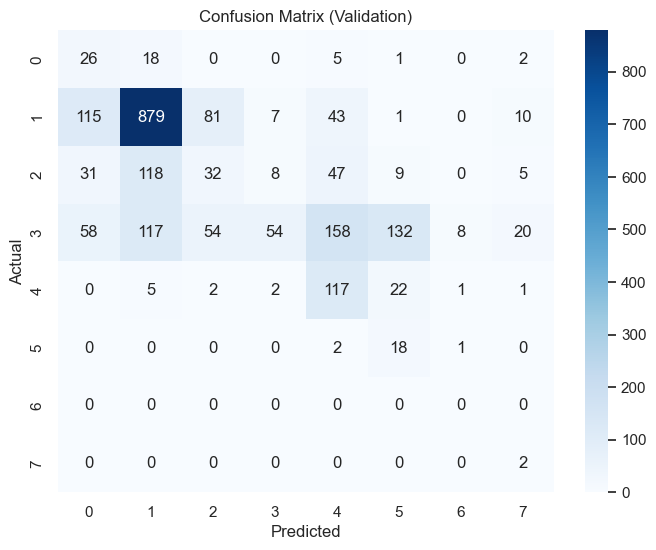

Final Random Forest Metrics:
Train Accuracy: 0.5252376641014034
Validation Accuracy: 0.5099457504520796
Train F1 Macro: 0.2675597188685366
Validation F1 Macro: 0.24890847664826982


In [60]:
# Train the final RandomForestClassifier model using the optimal number of estimators
rf_final = RandomForestClassifier(
    n_estimators=best_params_rf['n_estimators'],
    max_depth=best_params_rf['max_depth'],
    min_samples_split=best_params_rf['min_samples_split'],
    min_samples_leaf=best_params_rf['min_samples_leaf'],
    random_state=42,
    class_weight=class_weight_dict
)

# Evaluate the model using the `evaluate_model` function
rf_optimized_final_metrics = evaluate_model(rf_final, X_train, y_train, X_val, y_val)

# Add metrics to metrics_df
metrics_df.loc['Random Forest Optimized'] = [
    rf_optimized_final_metrics['Train Accuracy'],
    rf_optimized_final_metrics['Validation Accuracy'],
    rf_optimized_final_metrics['Train F1 Macro'], 
    rf_optimized_final_metrics['Validation F1 Macro']
]

# Display the evaluation metrics
print("Final Random Forest Metrics:")
for metric, value in rf_optimized_final_metrics.items():
    print(f"{metric}: {value}")


### **MLP (Optimized)**

In [61]:
param_dist = {
    'hidden_layer_sizes': [(20,20), (10,10,10), (15, 15), (25, 25)],
    'activation': ['identity', 'logistic', 'tanh', 'relu'],
    'alpha': [0.0001, 0.001, 0.01, 0.1],
    'learning_rate': ['constant', 'invscaling', 'adaptive'],
    'max_iter': [200, 300, 500]  # Larger limits for complex data
}

# Initialize the RandomForestClassifier
mlp = MLPClassifier(solver='adam', random_state=42)

# RandomizedSearchCV
random_search_mlp = RandomizedSearchCV(
    estimator= mlp, 
    param_distributions=param_dist,
    n_iter=20,
    scoring='f1_macro', 
    cv=cv_strategy,
    n_jobs=-1,
    random_state=42
)

# Fit RandomizedSearchCV
random_search_mlp.fit(X_combined, y_combined)

# Get best parameters
best_params_MLP = random_search_mlp.best_params_

best_mlp = MLPClassifier(
    hidden_layer_sizes=best_params_MLP['hidden_layer_sizes'],
    activation=best_params_MLP['activation'],
    alpha=best_params_MLP['alpha'],
    learning_rate=best_params_MLP['learning_rate'],
    max_iter=best_params_MLP['max_iter'],
    solver='adam',
    random_state=42
)

best_mlp.fit(X_combined, y_combined)

# Print best parameters and score
print("Best parameters found:")
for param, value in best_params_MLP.items():
    print(f"{param}: {value}")
print(f"\nBest cross-validation score: {random_search_mlp.best_score_:.4f}")


/opt/anaconda3/lib/python3.12/site-packages/sklearn/neural_network/_multilayer_perceptron.py:1101: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)
/opt/anaconda3/lib/python3.12/site-packages/sklearn/neural_network/_multilayer_perceptron.py:1101: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)
/opt/anaconda3/lib/python3.12/site-packages/sklearn/neural_network/_multilayer_perceptron.py:1101: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)
/opt/anaconda3/lib/python3.12/site-packages/sklearn/neural_network/_multilayer_perceptron.py:1101: DataConversionWarning: A column-vecto

Best parameters found:
max_iter: 500
learning_rate: invscaling
hidden_layer_sizes: (25, 25)
alpha: 0.001
activation: tanh

Best cross-validation score: 0.4029


Training Data Evaluation:
Accuracy (Train): 0.6938
F1 Macro (Train): 0.3790

Validation Data Evaluation:
Accuracy (Validation): 0.6917
F1 Macro (Validation): 0.4029

Classification Report (Validation):
              precision    recall  f1-score   support

           0       0.32      0.13      0.19        52
           1       0.73      0.96      0.83      1136
           2       0.20      0.02      0.03       250
           3       0.66      0.61      0.64       601
           4       0.54      0.42      0.47       150
           5       0.00      0.00      0.00        21
           7       1.00      0.50      0.67         2

    accuracy                           0.69      2212
   macro avg       0.49      0.38      0.40      2212
weighted avg       0.62      0.69      0.64      2212



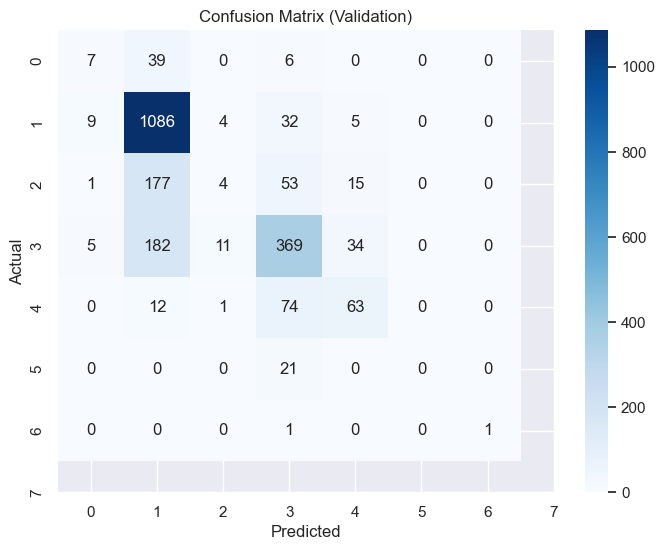

Final MLP Classifier Metrics:
Train Accuracy: 0.6937528293345405
Validation Accuracy: 0.6916817359855335
Train F1 Macro: 0.37902126125781155
Validation F1 Macro: 0.40292572669540666


In [62]:
# Train the final MLP model using the optimal hyperparameters
final_mlp = MLPClassifier(
    hidden_layer_sizes=random_search_mlp.best_params_['hidden_layer_sizes'],
    activation=random_search_mlp.best_params_['activation'],
    alpha=random_search_mlp.best_params_['alpha'],
    learning_rate=random_search_mlp.best_params_['learning_rate'],
    max_iter=random_search_mlp.best_params_['max_iter'],
    solver='adam',
    random_state=42
)

# Evaluate the model
final_mlp_metrics = evaluate_model(final_mlp, X_train, y_train, X_val,y_val)

# Add metrics to metrics_df
metrics_df.loc['MLP Optimized'] = [
    final_mlp_metrics['Train Accuracy'],
    final_mlp_metrics['Validation Accuracy'],
    final_mlp_metrics['Train F1 Macro'], 
    final_mlp_metrics['Validation F1 Macro']
]

# Display the evaluation metrics
print("Final MLP Classifier Metrics:")
for metric, value in final_mlp_metrics.items():
    print(f"{metric}: {value}")


### **XGBoost(Optimized)**

In [63]:
# Define parameter distribution for RandomizedSearchCV
param_dist = {
    'n_estimators': [50, 100, 200],  # Reduced range due to dataset size
    'max_depth': [3, 5, 7],          # Shallow trees to prevent overfitting
    'learning_rate': [0.1, 0.3],     # Larger learning rates for faster convergence
    'min_child_weight': [3, 5],      # Higher values for large dataset
    'gamma': [0, 0.1],               # Minimal gamma values
    'subsample': [0.6, 0.8],         # Subsampling for faster training
    'colsample_bytree': [0.6, 0.8],  # Feature sampling for faster training
    'reg_alpha': [0, 1.0],           # L1 regularization
    'reg_lambda': [1.0, 5.0]         # L2 regularization
}

# Initialize base XGBoost model
xgb_base = XGBClassifier(
    objective='multi:softmax',
    num_class=8,
    random_state=42,
    use_label_encoder=False,
    eval_metric='mlogloss',
    tree_method='hist',        # Faster tree method for large datasets
    enable_categorical=False   # Disable categorical feature support for speed
)

# Set up RandomizedSearchCV
random_search = RandomizedSearchCV(
    estimator=xgb_base,
    param_distributions=param_dist,
    n_iter=20,                # Reduced number of iterations
    scoring='f1_macro',
    cv=cv_strategy,
    verbose=2,
    n_jobs=-1,
    random_state=42
)

# Fit RandomizedSearchCV
random_search.fit(X_combined, y_combined.values.ravel())

# Get the best parameters
best_params_xgb = random_search.best_params_

# Model with best parameters
best_xgb = XGBClassifier(
    n_estimators=best_params_xgb['n_estimators'],
    max_depth=best_params_xgb['max_depth'],
    learning_rate=best_params_xgb['learning_rate'],
    min_child_weight=best_params_xgb['min_child_weight'],
    gamma=best_params_xgb['gamma'],
    subsample=best_params_xgb['subsample'],
    colsample_bytree=best_params_xgb['colsample_bytree'],
    reg_alpha=best_params_xgb['reg_alpha'],
    reg_lambda=best_params_xgb['reg_lambda'],
    objective='multi:softmax',
    num_class=8,
    random_state=42,
    use_label_encoder=False,
    eval_metric='mlogloss',
    tree_method='hist'
)

# Print best parameters and score
print("\nBest parameters found:")
print(random_search.best_params_)
print("\nBest F1 macro score:")
print(random_search.best_score_)


Fitting 1 folds for each of 20 candidates, totalling 20 fits


/opt/anaconda3/lib/python3.12/site-packages/xgboost/core.py:158: UserWarning: [04:43:11] WARNING: /Users/runner/work/xgboost/xgboost/src/learner.cc:740: 
Parameters: { "use_label_encoder" } are not used.

  warnings.warn(smsg, UserWarning)
/opt/anaconda3/lib/python3.12/site-packages/xgboost/core.py:158: UserWarning: [04:43:11] WARNING: /Users/runner/work/xgboost/xgboost/src/learner.cc:740: 
Parameters: { "use_label_encoder" } are not used.

  warnings.warn(smsg, UserWarning)
/opt/anaconda3/lib/python3.12/site-packages/xgboost/core.py:158: UserWarning: [04:43:11] WARNING: /Users/runner/work/xgboost/xgboost/src/learner.cc:740: 
Parameters: { "use_label_encoder" } are not used.

  warnings.warn(smsg, UserWarning)
/opt/anaconda3/lib/python3.12/site-packages/xgboost/core.py:158: UserWarning: [04:43:11] WARNING: /Users/runner/work/xgboost/xgboost/src/learner.cc:740: 
Parameters: { "use_label_encoder" } are not used.

  warnings.warn(smsg, UserWarning)
/opt/anaconda3/lib/python3.12/site-packa

[CV] END colsample_bytree=0.6, gamma=0, learning_rate=0.3, max_depth=3, min_child_weight=5, n_estimators=50, reg_alpha=1.0, reg_lambda=5.0, subsample=0.6; total time=   0.3s
[CV] END colsample_bytree=0.6, gamma=0, learning_rate=0.3, max_depth=5, min_child_weight=5, n_estimators=50, reg_alpha=0, reg_lambda=5.0, subsample=0.6; total time=   0.5s


/opt/anaconda3/lib/python3.12/site-packages/xgboost/core.py:158: UserWarning: [04:43:12] WARNING: /Users/runner/work/xgboost/xgboost/src/learner.cc:740: 
Parameters: { "use_label_encoder" } are not used.

  warnings.warn(smsg, UserWarning)
/opt/anaconda3/lib/python3.12/site-packages/xgboost/core.py:158: UserWarning: [04:43:12] WARNING: /Users/runner/work/xgboost/xgboost/src/learner.cc:740: 
Parameters: { "use_label_encoder" } are not used.

  warnings.warn(smsg, UserWarning)


[CV] END colsample_bytree=0.6, gamma=0.1, learning_rate=0.3, max_depth=7, min_child_weight=5, n_estimators=50, reg_alpha=0, reg_lambda=5.0, subsample=0.6; total time=   0.6s
[CV] END colsample_bytree=0.8, gamma=0, learning_rate=0.1, max_depth=5, min_child_weight=3, n_estimators=50, reg_alpha=1.0, reg_lambda=1.0, subsample=0.8; total time=   0.6s
[CV] END colsample_bytree=0.8, gamma=0, learning_rate=0.3, max_depth=3, min_child_weight=5, n_estimators=100, reg_alpha=0, reg_lambda=5.0, subsample=0.6; total time=   0.7s
[CV] END colsample_bytree=0.6, gamma=0, learning_rate=0.3, max_depth=7, min_child_weight=3, n_estimators=50, reg_alpha=0, reg_lambda=1.0, subsample=0.6; total time=   0.7s


/opt/anaconda3/lib/python3.12/site-packages/xgboost/core.py:158: UserWarning: [04:43:12] WARNING: /Users/runner/work/xgboost/xgboost/src/learner.cc:740: 
Parameters: { "use_label_encoder" } are not used.

  warnings.warn(smsg, UserWarning)
/opt/anaconda3/lib/python3.12/site-packages/xgboost/core.py:158: UserWarning: [04:43:12] WARNING: /Users/runner/work/xgboost/xgboost/src/learner.cc:740: 
Parameters: { "use_label_encoder" } are not used.

  warnings.warn(smsg, UserWarning)
/opt/anaconda3/lib/python3.12/site-packages/xgboost/core.py:158: UserWarning: [04:43:12] WARNING: /Users/runner/work/xgboost/xgboost/src/learner.cc:740: 
Parameters: { "use_label_encoder" } are not used.

  warnings.warn(smsg, UserWarning)
/opt/anaconda3/lib/python3.12/site-packages/xgboost/core.py:158: UserWarning: [04:43:12] WARNING: /Users/runner/work/xgboost/xgboost/src/learner.cc:740: 
Parameters: { "use_label_encoder" } are not used.

  warnings.warn(smsg, UserWarning)
/opt/anaconda3/lib/python3.12/site-packa

[CV] END colsample_bytree=0.8, gamma=0, learning_rate=0.1, max_depth=3, min_child_weight=3, n_estimators=100, reg_alpha=0, reg_lambda=1.0, subsample=0.6; total time=   0.8s
[CV] END colsample_bytree=0.8, gamma=0, learning_rate=0.3, max_depth=5, min_child_weight=5, n_estimators=50, reg_alpha=1.0, reg_lambda=1.0, subsample=0.6; total time=   0.5s
[CV] END colsample_bytree=0.6, gamma=0, learning_rate=0.3, max_depth=7, min_child_weight=5, n_estimators=50, reg_alpha=0, reg_lambda=1.0, subsample=0.8; total time=   0.6s
[CV] END colsample_bytree=0.6, gamma=0.1, learning_rate=0.1, max_depth=5, min_child_weight=3, n_estimators=100, reg_alpha=1.0, reg_lambda=5.0, subsample=0.8; total time=   0.9s


/opt/anaconda3/lib/python3.12/site-packages/xgboost/core.py:158: UserWarning: [04:43:13] WARNING: /Users/runner/work/xgboost/xgboost/src/learner.cc:740: 
Parameters: { "use_label_encoder" } are not used.

  warnings.warn(smsg, UserWarning)
/opt/anaconda3/lib/python3.12/site-packages/xgboost/core.py:158: UserWarning: [04:43:13] WARNING: /Users/runner/work/xgboost/xgboost/src/learner.cc:740: 
Parameters: { "use_label_encoder" } are not used.

  warnings.warn(smsg, UserWarning)
/opt/anaconda3/lib/python3.12/site-packages/xgboost/core.py:158: UserWarning: [04:43:13] WARNING: /Users/runner/work/xgboost/xgboost/src/learner.cc:740: 
Parameters: { "use_label_encoder" } are not used.

  warnings.warn(smsg, UserWarning)


[CV] END colsample_bytree=0.6, gamma=0.1, learning_rate=0.1, max_depth=3, min_child_weight=3, n_estimators=50, reg_alpha=0, reg_lambda=1.0, subsample=0.8; total time=   0.3s
[CV] END colsample_bytree=0.8, gamma=0.1, learning_rate=0.1, max_depth=5, min_child_weight=3, n_estimators=100, reg_alpha=1.0, reg_lambda=1.0, subsample=0.6; total time=   1.0s
[CV] END colsample_bytree=0.6, gamma=0.1, learning_rate=0.3, max_depth=3, min_child_weight=3, n_estimators=100, reg_alpha=1.0, reg_lambda=5.0, subsample=0.8; total time=   0.6s
[CV] END colsample_bytree=0.6, gamma=0.1, learning_rate=0.1, max_depth=3, min_child_weight=5, n_estimators=200, reg_alpha=0, reg_lambda=1.0, subsample=0.6; total time=   1.3s


/opt/anaconda3/lib/python3.12/site-packages/xgboost/core.py:158: UserWarning: [04:43:13] WARNING: /Users/runner/work/xgboost/xgboost/src/learner.cc:740: 
Parameters: { "use_label_encoder" } are not used.

  warnings.warn(smsg, UserWarning)
/opt/anaconda3/lib/python3.12/site-packages/xgboost/core.py:158: UserWarning: [04:43:13] WARNING: /Users/runner/work/xgboost/xgboost/src/learner.cc:740: 
Parameters: { "use_label_encoder" } are not used.

  warnings.warn(smsg, UserWarning)


[CV] END colsample_bytree=0.8, gamma=0, learning_rate=0.1, max_depth=5, min_child_weight=5, n_estimators=100, reg_alpha=0, reg_lambda=1.0, subsample=0.8; total time=   1.0s
[CV] END colsample_bytree=0.8, gamma=0, learning_rate=0.1, max_depth=7, min_child_weight=5, n_estimators=50, reg_alpha=1.0, reg_lambda=1.0, subsample=0.8; total time=   0.6s
[CV] END colsample_bytree=0.6, gamma=0, learning_rate=0.3, max_depth=5, min_child_weight=5, n_estimators=50, reg_alpha=1.0, reg_lambda=1.0, subsample=0.6; total time=   0.4s
[CV] END colsample_bytree=0.6, gamma=0.1, learning_rate=0.3, max_depth=3, min_child_weight=3, n_estimators=50, reg_alpha=0, reg_lambda=1.0, subsample=0.6; total time=   0.3s
[CV] END colsample_bytree=0.8, gamma=0, learning_rate=0.1, max_depth=7, min_child_weight=5, n_estimators=200, reg_alpha=0, reg_lambda=5.0, subsample=0.8; total time=   2.3s
[CV] END colsample_bytree=0.8, gamma=0, learning_rate=0.1, max_depth=7, min_child_weight=3, n_estimators=200, reg_alpha=1.0, reg_lam

Training Data Evaluation:
Accuracy (Train): 0.7803
F1 Macro (Train): 0.3719

Validation Data Evaluation:
Accuracy (Validation): 0.7116
F1 Macro (Validation): 0.3113

Classification Report (Validation):
              precision    recall  f1-score   support

           0       0.40      0.12      0.18        52
           1       0.75      0.97      0.85      1136
           2       0.11      0.00      0.01       250
           3       0.67      0.66      0.67       601
           4       0.52      0.44      0.48       150
           5       0.00      0.00      0.00        21
           7       0.00      0.00      0.00         2

    accuracy                           0.71      2212
   macro avg       0.35      0.31      0.31      2212
weighted avg       0.63      0.71      0.65      2212



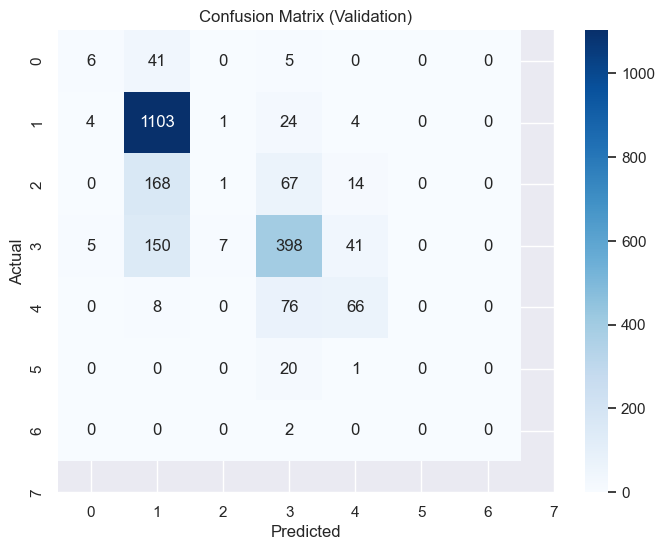


Final XGBoost Model Metrics (Sampled Data):
Train Accuracy: 0.7803304662743322
Validation Accuracy: 0.7115732368896925
Train F1 Macro: 0.3718577046498364
Validation F1 Macro: 0.3112601278863299


In [64]:
# Train the final model with best parameters on sampled training data
final_xgb_model = XGBClassifier(
    learning_rate=0.1,
    n_estimators=best_params_xgb['n_estimators'],
    max_depth=best_params_xgb['max_depth'],
    min_child_weight=best_params_xgb['min_child_weight'], 
    gamma=best_params_xgb['gamma'],
    subsample=best_params_xgb['subsample'],
    colsample_bytree=best_params_xgb['colsample_bytree'],
    objective='multi:softprob',
    num_class=8,
    random_state=42,
    eval_metric='mlogloss',
)

# Evaluate the final XGBoost model using sampled validation data
final_xgb_metrics = evaluate_model(final_xgb_model, X_train, y_train, X_val, y_val)

# Add XGBoost metrics to metrics_df
metrics_df.loc['XGBoost Optimized'] = [
    final_xgb_metrics['Train Accuracy'],
    final_xgb_metrics['Validation Accuracy'],
    final_xgb_metrics['Train F1 Macro'], 
    final_xgb_metrics['Validation F1 Macro']
]

# Display the final evaluation metrics
print("\nFinal XGBoost Model Metrics (Sampled Data):")
for metric, value in final_xgb_metrics.items():
    print(f"{metric}: {value}")

### **Bagging (Optimized)**

In [66]:
# Define the parameter grid for RandomizedSearchCV
param_dist = {
    'max_samples': [0.5, 0.7, 1.0],         
    'max_features': [0.5, 0.7, 1.0],              
    'bootstrap': [True, False],                  
    'bootstrap_features': [True, False],          
    'estimator': [
        DecisionTreeClassifier(max_depth=5),      
        DecisionTreeClassifier(max_depth=None)   
    ]
}

# Initialize the BaggingClassifier with a default number of estimators
bagging = BaggingClassifier(
    n_estimators=100, 
    random_state=42,
    n_jobs=-1       
)

# Set up RandomizedSearchCV
random_search_bagging = RandomizedSearchCV(
    estimator=bagging,
    param_distributions=param_dist,
    n_iter=50,        
    scoring='f1_macro',     
    cv=cv_strategy,          
    verbose=2,
    n_jobs=-1,             
    random_state=42
)

# Fit RandomizedSearchCV on the dataset
random_search_bagging.fit(X_combined, y_combined)

# Get best parameters
best_params_bagging = random_search_bagging.best_params_

# Model with best parameters
best_bagging = BaggingClassifier(
    n_estimators=100, 
    max_samples=best_params_bagging['max_samples'],
    max_features=best_params_bagging['max_features'],
    bootstrap=best_params_bagging['bootstrap'],
    bootstrap_features=best_params_bagging['bootstrap_features'],
    estimator=best_params_bagging['estimator'],
    random_state=42,
    n_jobs=-1
)

best_bagging.fit(X_combined, y_combined)

# Print best parameters and score
print("Best parameters found:")
for param, value in best_params_bagging.items():
    print(f"{param}: {value}")
print(f"\nBest cross-validation score: {random_search_bagging.best_score_:.4f}")


Fitting 1 folds for each of 50 candidates, totalling 50 fits


/opt/anaconda3/lib/python3.12/site-packages/sklearn/ensemble/_bagging.py:782: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)
/opt/anaconda3/lib/python3.12/site-packages/sklearn/ensemble/_bagging.py:782: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)
/opt/anaconda3/lib/python3.12/site-packages/sklearn/ensemble/_bagging.py:782: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)
/opt/anaconda3/lib/python3.12/site-packages/sklearn/ensemble/_bagging.py:782: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samp

[CV] END bootstrap=True, bootstrap_features=True, estimator=DecisionTreeClassifier(max_depth=5), max_features=0.5, max_samples=0.5; total time=   1.2s
[CV] END bootstrap=True, bootstrap_features=False, estimator=DecisionTreeClassifier(max_depth=5), max_features=0.5, max_samples=0.5; total time=   1.4s


/opt/anaconda3/lib/python3.12/site-packages/sklearn/ensemble/_bagging.py:782: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)
/opt/anaconda3/lib/python3.12/site-packages/sklearn/ensemble/_bagging.py:782: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)


[CV] END bootstrap=True, bootstrap_features=True, estimator=DecisionTreeClassifier(max_depth=5), max_features=0.7, max_samples=0.7; total time=   2.0s


/opt/anaconda3/lib/python3.12/site-packages/sklearn/ensemble/_bagging.py:782: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)


[CV] END bootstrap=False, bootstrap_features=False, estimator=DecisionTreeClassifier(max_depth=5), max_features=0.5, max_samples=0.5; total time=   1.4s


/opt/anaconda3/lib/python3.12/site-packages/sklearn/ensemble/_bagging.py:782: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)


[CV] END bootstrap=True, bootstrap_features=True, estimator=DecisionTreeClassifier(), max_features=0.5, max_samples=0.7; total time=   3.2s
[CV] END bootstrap=True, bootstrap_features=False, estimator=DecisionTreeClassifier(), max_features=0.5, max_samples=0.7; total time=   3.5s


/opt/anaconda3/lib/python3.12/site-packages/sklearn/ensemble/_bagging.py:782: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)
/opt/anaconda3/lib/python3.12/site-packages/sklearn/ensemble/_bagging.py:782: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)


[CV] END bootstrap=False, bootstrap_features=False, estimator=DecisionTreeClassifier(max_depth=5), max_features=1.0, max_samples=1.0; total time=   3.9s


/opt/anaconda3/lib/python3.12/site-packages/sklearn/ensemble/_bagging.py:782: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)


[CV] END bootstrap=True, bootstrap_features=True, estimator=DecisionTreeClassifier(), max_features=0.7, max_samples=0.5; total time=   3.2s


/opt/anaconda3/lib/python3.12/site-packages/sklearn/ensemble/_bagging.py:782: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)


[CV] END bootstrap=True, bootstrap_features=True, estimator=DecisionTreeClassifier(max_depth=5), max_features=0.7, max_samples=1.0; total time=   1.8s
[CV] END bootstrap=True, bootstrap_features=True, estimator=DecisionTreeClassifier(), max_features=0.5, max_samples=0.5; total time=   2.5s


/opt/anaconda3/lib/python3.12/site-packages/sklearn/ensemble/_bagging.py:782: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)
/opt/anaconda3/lib/python3.12/site-packages/sklearn/ensemble/_bagging.py:782: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)


[CV] END bootstrap=True, bootstrap_features=False, estimator=DecisionTreeClassifier(max_depth=5), max_features=0.7, max_samples=0.7; total time=   1.7s


/opt/anaconda3/lib/python3.12/site-packages/sklearn/ensemble/_bagging.py:782: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)


[CV] END bootstrap=True, bootstrap_features=False, estimator=DecisionTreeClassifier(), max_features=1.0, max_samples=0.7; total time=   6.4s
[CV] END bootstrap=False, bootstrap_features=True, estimator=DecisionTreeClassifier(), max_features=0.5, max_samples=0.5; total time=   3.2s


/opt/anaconda3/lib/python3.12/site-packages/sklearn/ensemble/_bagging.py:782: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)
/opt/anaconda3/lib/python3.12/site-packages/sklearn/ensemble/_bagging.py:782: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)


[CV] END bootstrap=True, bootstrap_features=False, estimator=DecisionTreeClassifier(), max_features=0.7, max_samples=0.7; total time=   4.3s


/opt/anaconda3/lib/python3.12/site-packages/sklearn/ensemble/_bagging.py:782: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)


[CV] END bootstrap=False, bootstrap_features=False, estimator=DecisionTreeClassifier(max_depth=5), max_features=0.5, max_samples=1.0; total time=   2.1s


/opt/anaconda3/lib/python3.12/site-packages/sklearn/ensemble/_bagging.py:782: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)


[CV] END bootstrap=False, bootstrap_features=True, estimator=DecisionTreeClassifier(), max_features=0.5, max_samples=1.0; total time=   6.1s
[CV] END bootstrap=False, bootstrap_features=True, estimator=DecisionTreeClassifier(max_depth=5), max_features=0.7, max_samples=0.5; total time=   1.6s
[CV] END bootstrap=False, bootstrap_features=True, estimator=DecisionTreeClassifier(), max_features=0.7, max_samples=1.0; total time=   8.1s


/opt/anaconda3/lib/python3.12/site-packages/sklearn/ensemble/_bagging.py:782: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)
/opt/anaconda3/lib/python3.12/site-packages/sklearn/ensemble/_bagging.py:782: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)
/opt/anaconda3/lib/python3.12/site-packages/sklearn/ensemble/_bagging.py:782: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)


[CV] END bootstrap=False, bootstrap_features=False, estimator=DecisionTreeClassifier(max_depth=5), max_features=0.7, max_samples=1.0; total time=   2.7s


/opt/anaconda3/lib/python3.12/site-packages/sklearn/ensemble/_bagging.py:782: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)


[CV] END bootstrap=True, bootstrap_features=True, estimator=DecisionTreeClassifier(max_depth=5), max_features=1.0, max_samples=0.7; total time=   2.4s


/opt/anaconda3/lib/python3.12/site-packages/sklearn/ensemble/_bagging.py:782: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)


[CV] END bootstrap=False, bootstrap_features=False, estimator=DecisionTreeClassifier(max_depth=5), max_features=0.5, max_samples=0.7; total time=   1.6s


/opt/anaconda3/lib/python3.12/site-packages/sklearn/ensemble/_bagging.py:782: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)


[CV] END bootstrap=True, bootstrap_features=False, estimator=DecisionTreeClassifier(), max_features=1.0, max_samples=0.5; total time=   5.2s


/opt/anaconda3/lib/python3.12/site-packages/sklearn/ensemble/_bagging.py:782: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)


[CV] END bootstrap=False, bootstrap_features=True, estimator=DecisionTreeClassifier(), max_features=0.7, max_samples=0.7; total time=   5.9s


/opt/anaconda3/lib/python3.12/site-packages/sklearn/ensemble/_bagging.py:782: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)


[CV] END bootstrap=False, bootstrap_features=True, estimator=DecisionTreeClassifier(max_depth=5), max_features=1.0, max_samples=1.0; total time=   4.1s


/opt/anaconda3/lib/python3.12/site-packages/sklearn/ensemble/_bagging.py:782: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)


[CV] END bootstrap=False, bootstrap_features=True, estimator=DecisionTreeClassifier(max_depth=5), max_features=1.0, max_samples=0.5; total time=   2.3s


/opt/anaconda3/lib/python3.12/site-packages/sklearn/ensemble/_bagging.py:782: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)


[CV] END bootstrap=True, bootstrap_features=False, estimator=DecisionTreeClassifier(max_depth=5), max_features=0.5, max_samples=0.7; total time=   1.3s
[CV] END bootstrap=True, bootstrap_features=True, estimator=DecisionTreeClassifier(), max_features=1.0, max_samples=0.7; total time=   6.5s


/opt/anaconda3/lib/python3.12/site-packages/sklearn/ensemble/_bagging.py:782: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)
/opt/anaconda3/lib/python3.12/site-packages/sklearn/ensemble/_bagging.py:782: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)


[CV] END bootstrap=True, bootstrap_features=False, estimator=DecisionTreeClassifier(), max_features=0.7, max_samples=0.5; total time=   3.3s


/opt/anaconda3/lib/python3.12/site-packages/sklearn/ensemble/_bagging.py:782: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)


[CV] END bootstrap=False, bootstrap_features=False, estimator=DecisionTreeClassifier(), max_features=1.0, max_samples=0.5; total time=   6.5s


/opt/anaconda3/lib/python3.12/site-packages/sklearn/ensemble/_bagging.py:782: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)


[CV] END bootstrap=False, bootstrap_features=False, estimator=DecisionTreeClassifier(max_depth=5), max_features=0.7, max_samples=0.7; total time=   2.3s


/opt/anaconda3/lib/python3.12/site-packages/sklearn/ensemble/_bagging.py:782: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)


[CV] END bootstrap=False, bootstrap_features=True, estimator=DecisionTreeClassifier(max_depth=5), max_features=0.7, max_samples=0.7; total time=   1.9s


/opt/anaconda3/lib/python3.12/site-packages/sklearn/ensemble/_bagging.py:782: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)


[CV] END bootstrap=True, bootstrap_features=False, estimator=DecisionTreeClassifier(max_depth=5), max_features=1.0, max_samples=0.7; total time=   2.3s
[CV] END bootstrap=False, bootstrap_features=True, estimator=DecisionTreeClassifier(), max_features=0.5, max_samples=0.7; total time=   4.5s


/opt/anaconda3/lib/python3.12/site-packages/sklearn/ensemble/_bagging.py:782: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)
/opt/anaconda3/lib/python3.12/site-packages/sklearn/ensemble/_bagging.py:782: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)


[CV] END bootstrap=True, bootstrap_features=False, estimator=DecisionTreeClassifier(), max_features=1.0, max_samples=1.0; total time=   8.4s


/opt/anaconda3/lib/python3.12/site-packages/sklearn/ensemble/_bagging.py:782: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)


[CV] END bootstrap=True, bootstrap_features=True, estimator=DecisionTreeClassifier(max_depth=5), max_features=0.7, max_samples=0.5; total time=   1.4s


/opt/anaconda3/lib/python3.12/site-packages/sklearn/ensemble/_bagging.py:782: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)


[CV] END bootstrap=False, bootstrap_features=False, estimator=DecisionTreeClassifier(max_depth=5), max_features=0.7, max_samples=0.5; total time=   1.6s


/opt/anaconda3/lib/python3.12/site-packages/sklearn/ensemble/_bagging.py:782: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)


[CV] END bootstrap=False, bootstrap_features=True, estimator=DecisionTreeClassifier(max_depth=5), max_features=0.5, max_samples=1.0; total time=   2.3s


/opt/anaconda3/lib/python3.12/site-packages/sklearn/ensemble/_bagging.py:782: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)


[CV] END bootstrap=True, bootstrap_features=True, estimator=DecisionTreeClassifier(max_depth=5), max_features=1.0, max_samples=0.5; total time=   1.9s
[CV] END bootstrap=True, bootstrap_features=True, estimator=DecisionTreeClassifier(), max_features=0.7, max_samples=0.7; total time=   4.1s


/opt/anaconda3/lib/python3.12/site-packages/sklearn/ensemble/_bagging.py:782: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)
/opt/anaconda3/lib/python3.12/site-packages/sklearn/ensemble/_bagging.py:782: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)


[CV] END bootstrap=True, bootstrap_features=True, estimator=DecisionTreeClassifier(max_depth=5), max_features=1.0, max_samples=1.0; total time=   3.1s


/opt/anaconda3/lib/python3.12/site-packages/sklearn/ensemble/_bagging.py:782: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)


[CV] END bootstrap=False, bootstrap_features=True, estimator=DecisionTreeClassifier(max_depth=5), max_features=0.5, max_samples=0.5; total time=   1.5s


/opt/anaconda3/lib/python3.12/site-packages/sklearn/ensemble/_bagging.py:782: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)


[CV] END bootstrap=False, bootstrap_features=False, estimator=DecisionTreeClassifier(), max_features=0.5, max_samples=0.7; total time=   5.0s


/opt/anaconda3/lib/python3.12/site-packages/sklearn/ensemble/_bagging.py:782: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)


[CV] END bootstrap=True, bootstrap_features=False, estimator=DecisionTreeClassifier(), max_features=0.5, max_samples=0.5; total time=   3.0s
[CV] END bootstrap=False, bootstrap_features=True, estimator=DecisionTreeClassifier(max_depth=5), max_features=0.7, max_samples=1.0; total time=   2.7s
[CV] END bootstrap=False, bootstrap_features=False, estimator=DecisionTreeClassifier(), max_features=0.7, max_samples=0.5; total time=   4.4s
[CV] END bootstrap=True, bootstrap_features=True, estimator=DecisionTreeClassifier(), max_features=1.0, max_samples=0.5; total time=   4.3s
[CV] END bootstrap=True, bootstrap_features=True, estimator=DecisionTreeClassifier(), max_features=1.0, max_samples=1.0; total time=   7.9s
[CV] END bootstrap=False, bootstrap_features=False, estimator=DecisionTreeClassifier(), max_features=1.0, max_samples=1.0; total time=  12.0s
[CV] END bootstrap=False, bootstrap_features=False, estimator=DecisionTreeClassifier(), max_features=1.0, max_samples=0.7; total time=   5.9s
[

Training Data Evaluation:
Accuracy (Train): 1.0000
F1 Macro (Train): 1.0000

Validation Data Evaluation:
Accuracy (Validation): 0.7039
F1 Macro (Validation): 0.3162

Classification Report (Validation):
              precision    recall  f1-score   support

           0       0.38      0.10      0.15        52
           1       0.76      0.94      0.84      1136
           2       0.28      0.05      0.09       250
           3       0.66      0.67      0.67       601
           4       0.52      0.43      0.47       150
           5       0.00      0.00      0.00        21
           7       0.00      0.00      0.00         2

    accuracy                           0.70      2212
   macro avg       0.37      0.31      0.32      2212
weighted avg       0.64      0.70      0.66      2212



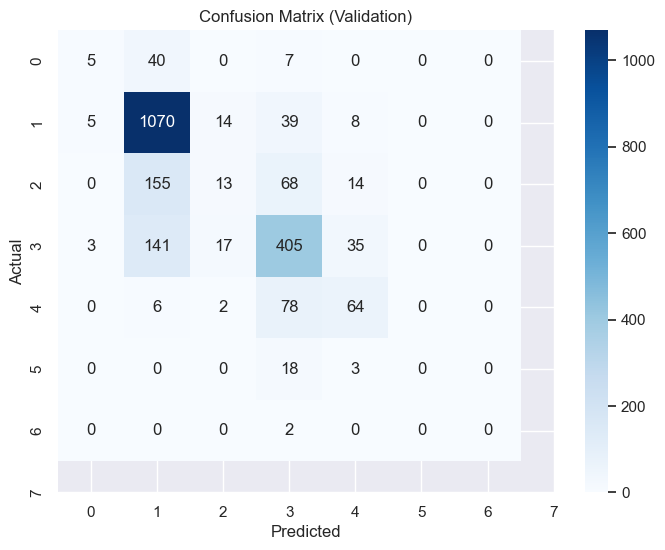

Final Bagging Classifier Metrics (Sampled Data):
Train Accuracy: 1.0
Validation Accuracy: 0.703887884267631
Train F1 Macro: 1.0
Validation F1 Macro: 0.31624804545719704


In [67]:
# Train the final BaggingClassifier model using the best parameters
final_bagging = BaggingClassifier(
    estimator=random_search_bagging.best_params_['estimator'], 
    n_estimators=100,  
    max_samples=random_search_bagging.best_params_['max_samples'], 
    max_features=random_search_bagging.best_params_['max_features'], 
    bootstrap=random_search_bagging.best_params_['bootstrap'],  
    bootstrap_features=random_search_bagging.best_params_['bootstrap_features'],  
    random_state=42
)

# Evaluate the final BaggingClassifier model on sampled data
Bagging_optimized_metrics = evaluate_model(final_bagging, X_train, y_train, X_val, y_val)

# Add Bagging metrics to metrics_df
metrics_df.loc['Bagging_optimized'] = [
    Bagging_optimized_metrics['Train Accuracy'],
    Bagging_optimized_metrics['Validation Accuracy'], 
    Bagging_optimized_metrics['Train F1 Macro'],
    Bagging_optimized_metrics['Validation F1 Macro']
]

# Display final model metrics
print("Final Bagging Classifier Metrics (Sampled Data):")
for metric, value in Bagging_optimized_metrics.items():
    print(f"{metric}: {value}")



### **Comparison for optimized models**

In [68]:
# remove the models that were not optimized
metrics_df.drop(['KNN', 'Naive Bayes', 'HistGradientBoosting', 'AdaBoost', 'Gradient Boosting','Logistic Regression'], inplace=True)

<Figure size 1200x600 with 0 Axes>

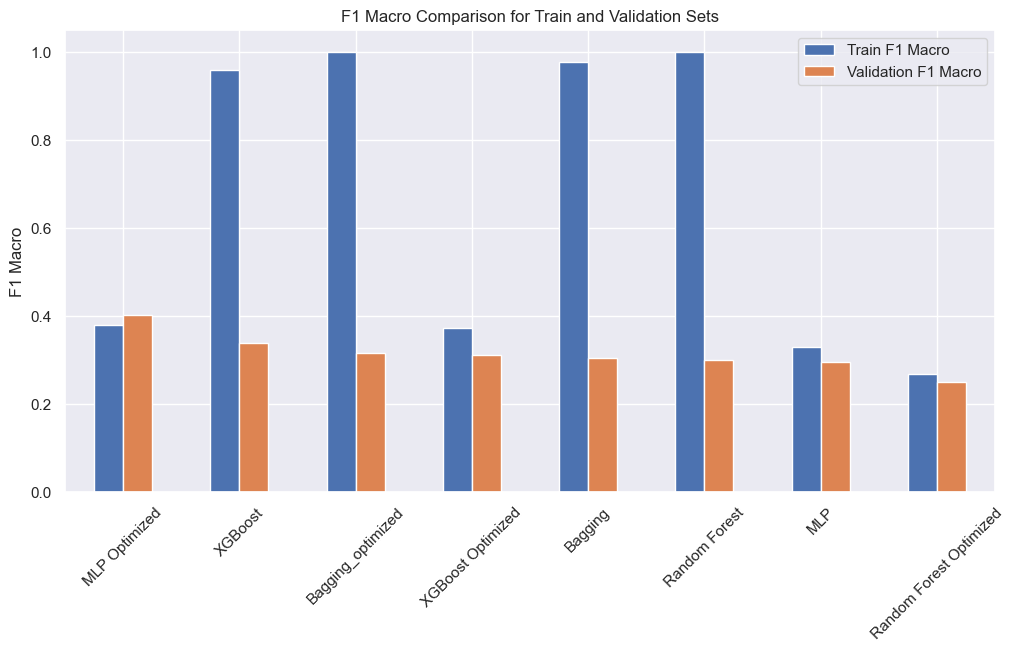

In [69]:
plot_metrics_df(metrics_df)

## Embedded Methods with the best performing models

### **Voting Classifier**

In [70]:
voting_clf = VotingClassifier(
    estimators=[
        ('bagging', final_bagging),
        ('rf', rf_final),
        ('xgb', final_xgb_model)
    ],
    voting='soft',
    n_jobs=-1
)

In [71]:
# Train the ensemble model
voting_clf.fit(X_train.values, y_train.values)

# Make predictions on the training set
train_pred = voting_clf.predict(X_train)

# Make predictions on the validation set
val_pred = voting_clf.predict(X_val)

Training Data Evaluation:
Accuracy (Train): 0.9891
F1 Macro (Train): 0.9916

Validation Data Evaluation:
Accuracy (Validation): 0.7039
F1 Macro (Validation): 0.3205

Classification Report (Validation):
              precision    recall  f1-score   support

           0       0.31      0.17      0.22        52
           1       0.75      0.95      0.84      1136
           2       0.25      0.02      0.03       250
           3       0.68      0.64      0.66       601
           4       0.47      0.51      0.49       150
           5       0.00      0.00      0.00        21
           7       0.00      0.00      0.00         2

    accuracy                           0.70      2212
   macro avg       0.35      0.33      0.32      2212
weighted avg       0.64      0.70      0.65      2212



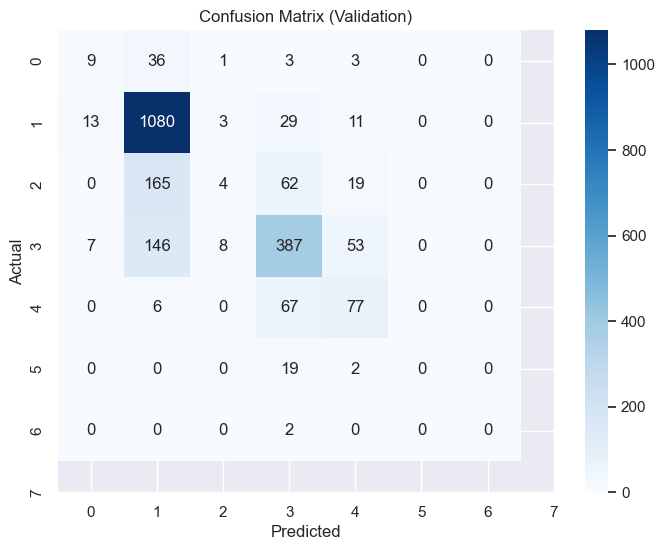

In [72]:
voting_clf_metrics = evaluate_model(voting_clf, X_train.values, y_train.values, X_val.values, y_val.values)

# Add voting classifier metrics to metrics_df
metrics_df.loc['Voting_Classifier'] = [
    voting_clf_metrics['Train Accuracy'],
    voting_clf_metrics['Validation Accuracy'],
    voting_clf_metrics['Train F1 Macro'], 
    voting_clf_metrics['Validation F1 Macro']
]

<Figure size 1200x600 with 0 Axes>

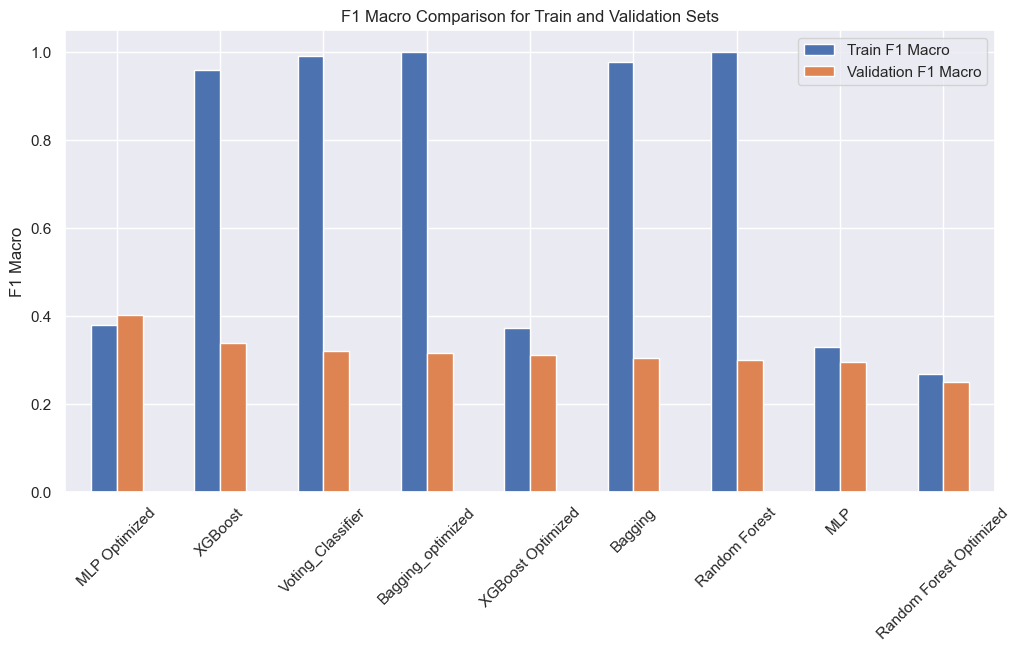

In [73]:
plot_metrics_df(metrics_df)

## **Kaggle Submissions**

In [74]:
def create_submission(model, X_test, filename):
    """
    Generate a submission file given a trained model and test features.

    Parameters
    ----------
    model : estimator
        A fitted machine learning model with a predict method.
    X_test : pd.DataFrame
        The test features. Must have 'Claim Identifier' as the index or a column.
    filename : str
        The name of the output CSV file.
    """
    # Make predictions
    pred = model.predict(X_test)

    # Define the mapping of numerical predictions to injury types
    label_mapping = {
        0: "1. CANCELLED",
        1: "2. NON-COMP",
        2: "3. MED ONLY",
        3: "4. TEMPORARY",
        4: "5. PPD SCH LOSS",
        5: "6. PPD NSL",
        6: "7. PTD",
        7: "8. DEATH",
        8: "Unknown"
    }

    # Map predictions to injury types
    predictions = [label_mapping[label] for label in pred]

    # Create submission DataFrame
    submission_df = pd.DataFrame({
        'Claim Identifier': X_test.index, 
        'Claim Injury Type': predictions
    })

    # Save to CSV
    submission_df.to_csv(filename, index=False)

In [75]:
create_submission(voting_clf, X_test, 'submissions/voting_submission.csv')

In [76]:
# Suppose you have a list of trained models and corresponding filenames
if not os.path.exists('submissions'):
    os.makedirs('submissions')
models = [final_xgb_model, final_mlp, rf_final, voting_clf]  # Replace with your models
filenames = ["submission_xgb.csv", "submission_mlp.csv","submission_rf.csv", "submission_voting.csv"]

for model, fname in zip(models, filenames):
    create_submission(model, X_test, fname)
    print(f"Created submission file: {fname}")

Created submission file: submission_xgb.csv
Created submission file: submission_mlp.csv
Created submission file: submission_rf.csv
Created submission file: submission_voting.csv
